## **Executive Summary**

### **Key Findings**

In this notebook, I relied on a RandomForest model to determine my benchmark model. I utilized it to determine which features played the most significant role in inducing salary variance. Moreover, I assumed a non-linear relationship among my dataset features.


### **Analyse how factors such as country, experience level, and remote ratio impact salaries for Data Analysts, Data Scientists, and Machine Learning Engineers. In which conditions do professionals achieve the highest salaries?**
- Country: Median salaries tended to be highest the countries of MX, PR, and US.
- Experience: Median salaries were highest for Executive, followed by Senior, Mid-level, and Entry-level
- Remote Ratio: Median Salaries were highest for pure on-site employees, whose salaries were only slightly higher than those of pure remote workers.

### **Develop a predictive model to estimate an employee’s salary (in USD) using experience level, company location, and remote ratio. Which features are the strongest predictors of salary?**
Using the RandomForest model and only features pertaining to experience level, company location, and remote ratio revealed that the most important features that determined salary level in descending order were **experience level**, **company location**, and finally **remote ratio**.

### **Expand your model by incorporating additional features, such as company size and employment type. Evaluate its performance, what improves, and what doesn’t? Finally, propose new features to make future salary predictions even more accurate future salary predictions even more accurate.**

I first incorporated a model that introduced company size and employment type; however these features delivered negligible improvement to the overall model quality. Moreover, the order of the top-3 feature importances remained undisturbed. **Experience level** remained the most importance feature.

Lastly, I incorporated work year and job title into the model building procedure: the former via ordinal encoding and the later via countvectorizer. This model achieved the best performance gains, achieving an RMSE score below 62000.

The **most important features** of this model were:
- job title has word 'analyst'
- experience level
- company location
- job title has word 'data'
- employee residence\


The features of **secondary importance** to explaining model performance were the following features:
- remote ratio
- work year
-  job title has word 'research'
-  job title has word 'engineer'
-  job title has word 'scientist'
-  job title has word 'developer'
-  job title has word 'intelligence'

## 📖 **Background**
You work for an international HR consultancy helping companies attract and retain top talent in the competitive tech industry. As part of your services, you provide clients with insights into industry salary trends to ensure they remain competitive in hiring and compensation practices.

Your team wants to use a data-driven approach to analyse how various factors—such as job role, experience level, remote work, and company size—impact salaries globally. By understanding these trends, you can advise clients on offering competitive packages to attract the best talent.

In this competition, you’ll explore and visualise salary data from thousands of employees worldwide. f you're tackling the advanced level, you'll go a step further—building predictive models to uncover key salary drivers and providing insights on how to enhance future data collection.

## 💾 **Data**

The data comes from a survey hosted by an HR consultancy, available in `'salaries.csv'`.

#### Each row represents a single employee's salary record for a given year:
- **`work_year`** - The year the salary was paid.  
- **`experience_level`** - Employee experience level:  
  - **`EN`**: Entry-level / Junior  
  - **`MI`**: Mid-level / Intermediate  
  - **`SE`**: Senior / Expert  
  - **`EX`**: Executive / Director  
- **`employment_type`** - Employment type:  
  - **`PT`**: Part-time  
  - **`FT`**: Full-time  
  - **`CT`**: Contract  
  - **`FL`**: Freelance  
- **`job_title`** - The job title during the year.  
- **`salary`** - Gross salary paid (in local currency).  
- **`salary_currency`** - Salary currency (ISO 4217 code).  
- **`salary_in_usd`** - Salary converted to USD using average yearly FX rate.  
- **`employee_residence`** - Employee's primary country of residence (ISO 3166 code).  
- **`remote_ratio`** - Percentage of remote work:  
  - **`0`**: No remote work (<20%)  
  - **`50`**: Hybrid (50%)  
  - **`100`**: Fully remote (>80%)  
- **`company_location`** - Employer's main office location (ISO 3166 code).  
- **`company_size`** - Company size:  
  - **`S`**: Small (<50 employees)  
  - **`M`**: Medium (50–250 employees)  
  - **`L`**: Large (>250 employees)  

In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from category_encoders import TargetEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import VarianceThreshold

# Custom functions
import nb_helpers as nb

In [2]:
df = pd.read_csv('data/salaries.csv')

df['job_title'] = df['job_title'].apply(lambda x: x.lower())
df['experience_level'] = df['experience_level'].apply(lambda x: x.lower())
df['employee_residence'] = df['employee_residence'].apply(lambda x: x.lower())
df['company_size'] = df['company_size'].apply(lambda x: x.lower())

df['company_location'] = nb.remap_company_location(df)

drop_cols = ['salary', 'salary_currency']
print(df.shape)
df = df.drop(drop_cols, axis = 1)
print(df.shape)


# useful containers
target = 'salary_in_usd'
salary_thereshold = df['salary_in_usd'].quantile(0.98)
models = []


df.head()

(57194, 11)
(57194, 9)


,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,mi,FT,developer,168276,us,0,US,m
1,2024,mi,FT,developer,112184,us,0,US,m
2,2024,en,FT,developer,180000,us,0,US,m
3,2024,en,FT,developer,133500,us,0,US,m
4,2024,en,FT,developer,122000,us,0,US,m


## Analyse how factors such as country, experience level, and remote ratio impact salaries for Data Analysts, Data Scientists, and Machine Learning Engineers. In which conditions do professionals achieve the highest salaries?

In [3]:
# Filter for Data Analysts, Data Scientists, and Machine Learning Engineers
roles_of_interest = ['data analyst', 'data scientist', 'machine learning engineer']
filtered_df = df[df['job_title'].isin(roles_of_interest)]


experience_map = {
    'se': 'senior',
    'mi': 'mid-level',
    'en': 'entry-level',
    'ex': 'executive'
}

# Task 1: Average salary by country, experience level, and remote ratio
salary_by_country = filtered_df.groupby('employee_residence')['salary_in_usd'].median().reset_index()
salary_by_country.columns = list(salary_by_country.columns[:1]) + ['median_salary']


count_by_country = filtered_df.groupby('employee_residence')['salary_in_usd'].count().reset_index()
count_by_country.columns = list(count_by_country.columns[:1]) + ['count_salary']

merge_cols = list(salary_by_country.columns[:1])

salary_df = pd.merge(salary_by_country, count_by_country, on = 'employee_residence').sort_values(by = "median_salary", ascending = False)
salary_threshold = salary_df['count_salary'].quantile(0.75)
salary_df = salary_df[salary_df['count_salary'] > salary_threshold].set_index('employee_residence')[['median_salary']]

<Figure size 1000x600 with 0 Axes>

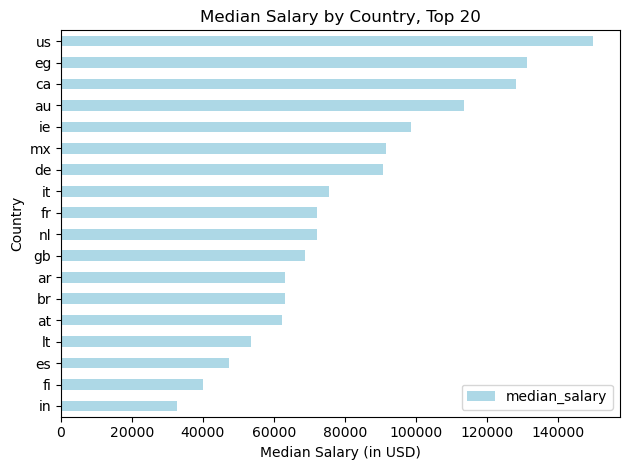

In [4]:
# Task 1: Visualize the results for salary impact analysis
top = 20

# Visualization for Salary by Country
plt.figure(figsize=(10, 6))
salary_df[:top][::-1].plot(kind='barh', color='lightblue')
plt.title(f'Median Salary by Country, Top {top}')
plt.xlabel('Median Salary (in USD)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

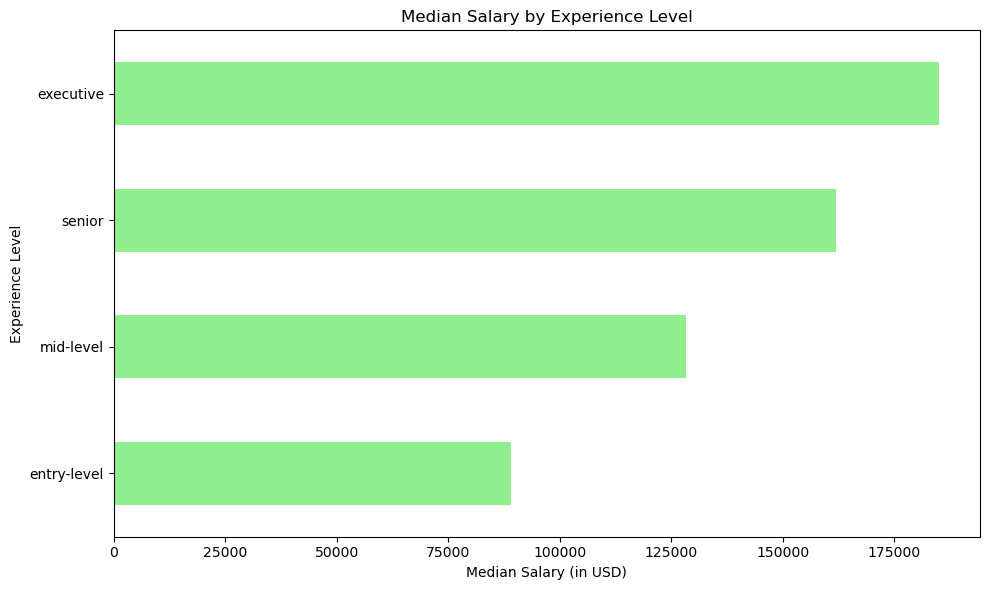

In [5]:
avg_salary_by_experience = filtered_df.groupby('experience_level')['salary_in_usd'].median().sort_values(ascending=False)
avg_salary_by_experience.index = [experience_map[role] for role in avg_salary_by_experience.index]

# Visualization for Average Salary by Experience Level
plt.figure(figsize=(10, 6))
avg_salary_by_experience[::-1].plot(kind='barh', color='lightgreen')
plt.title('Median Salary by Experience Level')
plt.xlabel('Median Salary (in USD)')
plt.ylabel('Experience Level')
plt.tight_layout()
plt.show()

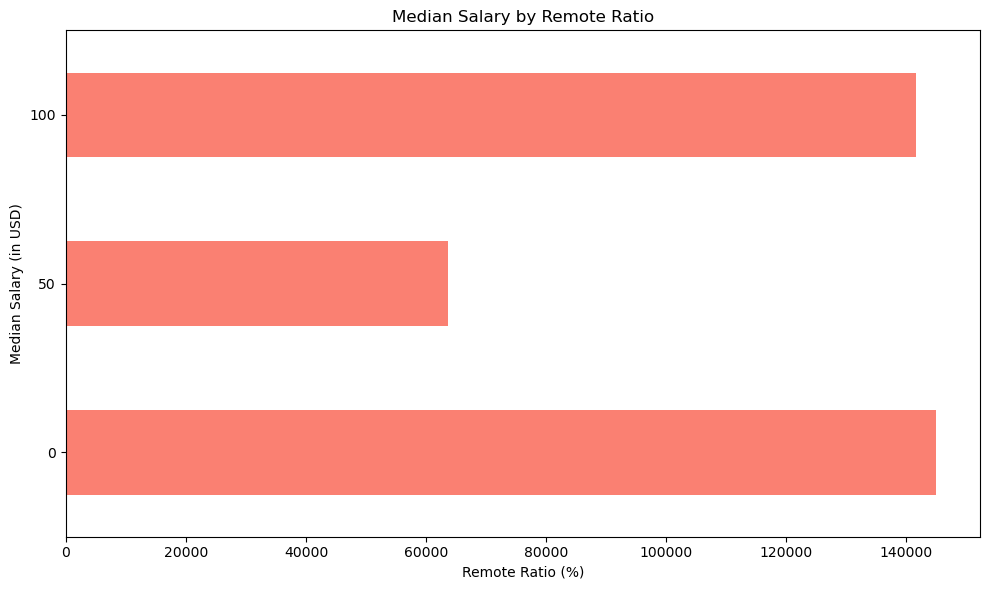

In [6]:
avg_salary_by_remote_ratio = filtered_df.groupby('remote_ratio')['salary_in_usd'].median()

# Visualization for Average Salary by Remote Ratio
plt.figure(figsize=(10, 6))
avg_salary_by_remote_ratio.plot(kind='barh', color='salmon')
plt.title('Median Salary by Remote Ratio')
plt.xlabel('Remote Ratio (%)')
plt.ylabel('Median Salary (in USD)')
plt.tight_layout()
plt.show()

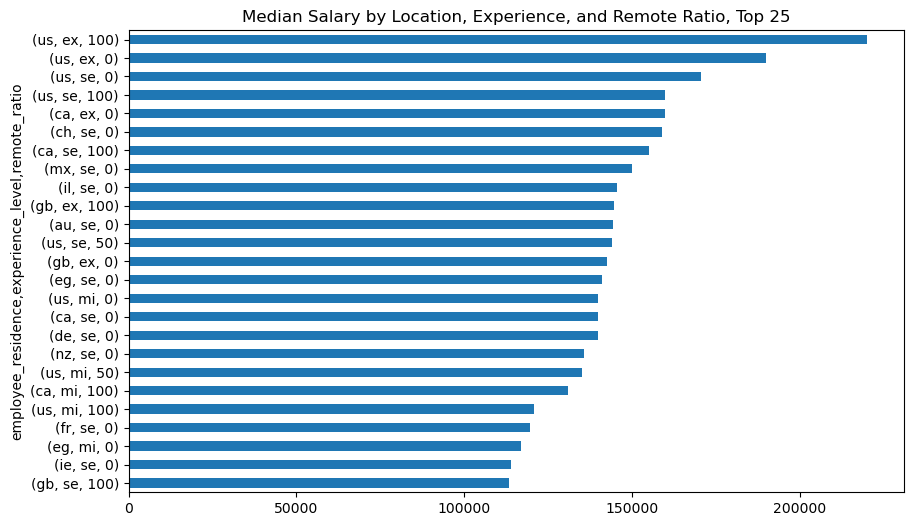

In [7]:
median_salaries = df.groupby(['employee_residence', 'experience_level', 'remote_ratio'])['salary_in_usd'].median().reset_index()
median_salaries.columns = list(median_salaries.columns[:3]) + ['median_salary']
count_salaries = df.groupby(['employee_residence', 'experience_level', 'remote_ratio'])['salary_in_usd'].count().reset_index()
count_salaries.columns = list(count_salaries.columns[:3]) + ['count_of_salary']

merge_cols = list(median_salaries.columns[:3])
salary_df = pd.merge(median_salaries, count_salaries, on = merge_cols).sort_values(by = 'median_salary', ascending = False)
salary_threshold = salary_df['count_of_salary'].quantile(0.75)
salary_df = salary_df[salary_df['count_of_salary'] > salary_threshold]
salary_df


top = 25
plt.figure(figsize=(10, 6))
salary_df.set_index(['employee_residence', 'experience_level', 'remote_ratio'])['median_salary'][:top][::-1].plot(kind = "barh")
plt.title(f'Median Salary by Location, Experience, and Remote Ratio, Top {top}')
plt.show()

## Develop a predictive model to estimate an employee’s salary (in USD) using experience level, company location, and remote ratio. Which features are the strongest predictors of salary?

In [8]:
df1 = df.copy()
df1 = df1.rename(columns = {'company_location': 'company_loc', 'job_title': 'job', 'employment_type': 'type'})
df1['remote_ratio'] = df1['remote_ratio'].astype(str)
df1['work_year'] = df1['work_year'].astype(str)

# Prepare the features (X) and target (y) for training the model
X = df1.drop(target, axis = 1)
y = df1[target]

### Model 1: Baseline

In [9]:
preprocessor = ColumnTransformer([
    ('ord_experience', OrdinalEncoder(categories = [['en', 'mi', 'se', 'ex']]), ['experience_level']),
    ('ord_remote_ratio', OrdinalEncoder(categories = [['0', '50', '100']]), ['remote_ratio']),
    ('target_enc_comp_loc', TargetEncoder(), ['company_loc']),
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('random_forest', RandomForestRegressor(random_state=42))
])

In [10]:
model_name = 'model 1 (baseline)'
result = cross_validate(pipeline, X, y, cv = 5, n_jobs = -1, scoring = 'neg_root_mean_squared_error')
rmse = -np.mean(result['test_score'])
models.append({'model': model_name, 'rmse': rmse})

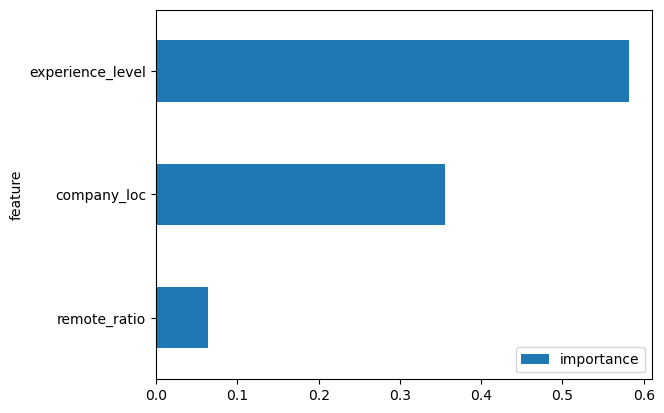

In [11]:
pipeline.fit(X, y)

feature_importances = list(pipeline.named_steps['random_forest'].feature_importances_)

feature_names = []

# Retrieve feature names from ColumnTransformer
for name, transformer, columns in preprocessor.transformers_:
    if isinstance(transformer, (OneHotEncoder, CountVectorizer)):
        # Extract feature names from OneHotEncoder and CountVectorizer
        if hasattr(transformer, 'get_feature_names_out'):
            transformed_names = transformer.get_feature_names_out(columns)
        else:
            transformed_names = columns  # Fallback if feature names are not available
    else:
        transformed_names = columns  # StandardScaler, OrdinalEncoder, etc.

    feature_names.extend(transformed_names)

feature_names = [f for f in feature_names if type(f)==str]

pd.DataFrame().from_dict({'feature': feature_names, 'importance': feature_importances}).sort_values(by='importance', ascending = True).set_index('feature').plot(kind = 'barh')
plt.show()

## Expand your model by incorporating additional features, such as company size and employment type. Evaluate its performance, what improves, and what doesn’t? 

### Model 2: Adding company size and employment type

In [12]:
preprocessor = ColumnTransformer([
    ('ord_experience', OrdinalEncoder(categories = [['en', 'mi', 'se', 'ex']]), ['experience_level']),
    ('ord_remote_ratio', OrdinalEncoder(categories = [['0', '50', '100']]), ['remote_ratio']),
    ('ord_enc_comp_size', OrdinalEncoder(categories = [['s','m','l']]), ['company_size']),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), ['type']),
    ('target_enc_comp_loc', TargetEncoder(), ['company_loc']),
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('random_forest', RandomForestRegressor(random_state=42))
])

In [13]:
model_name = 'model 2'
result = cross_validate(pipeline, X, y, cv = 5, n_jobs = -1, scoring = 'neg_root_mean_squared_error')
rmse = -np.mean(result['test_score'])
models.append({'model': model_name, 'rmse': rmse})

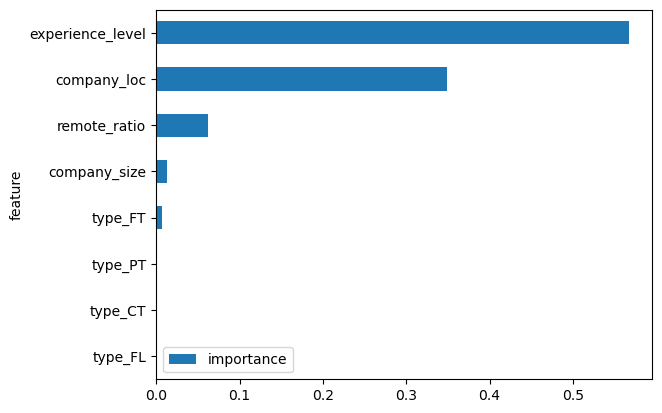

In [14]:
pipeline.fit(X, y)

feature_importances = list(pipeline.named_steps['random_forest'].feature_importances_)

feature_names = []

# Retrieve feature names from ColumnTransformer
for name, transformer, columns in preprocessor.transformers_:
    if isinstance(transformer, (OneHotEncoder, CountVectorizer)):
        # Extract feature names from OneHotEncoder and CountVectorizer
        if hasattr(transformer, 'get_feature_names_out'):
            transformed_names = transformer.get_feature_names_out(columns)
        else:
            transformed_names = columns  # Fallback if feature names are not available
    else:
        transformed_names = columns  # StandardScaler, OrdinalEncoder, etc.

    feature_names.extend(transformed_names)

feature_names = [f for f in feature_names if type(f)==str]

pd.DataFrame().from_dict({'feature': feature_names, 'importance': feature_importances}).sort_values(by='importance', ascending = True).set_index('feature').plot(kind = 'barh')
plt.show()

## Propose new features to make future salary predictions even more accurate future salary predictions even more accurate.

### Model 3: Add job title information

In [15]:
preprocessor = ColumnTransformer([
    ('ord_work_year', OrdinalEncoder(categories = [['2020', '2021', '2022', '2023', '2024']]), ['work_year']),
    ('ord_experience', OrdinalEncoder(categories = [['en', 'mi', 'se', 'ex']]), ['experience_level']),
    ('ord_remote_ratio', OrdinalEncoder(categories = [['0', '50', '100']]), ['remote_ratio']),
    ('ord_enc_comp_size', OrdinalEncoder(categories = [['s','m','l']]), ['company_size']),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), ['type']),
    ('countvectorizer_job', CountVectorizer(lowercase=True, binary=True, max_features = 20), 'job'),
    ('target_enc_emp_res', TargetEncoder(), ['employee_residence']),
    ('target_enc_comp_loc', TargetEncoder(), ['company_loc']),
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('random_forest', RandomForestRegressor(random_state=42))
])

In [16]:
model_name = 'model 3'
result = cross_validate(pipeline, X, y, cv = 5, n_jobs = -1, scoring = 'neg_root_mean_squared_error')
rmse = -np.mean(result['test_score'])
print(model_name, rmse)
models.append({'model': model_name, 'rmse': rmse})

model 3 61946.20681899914


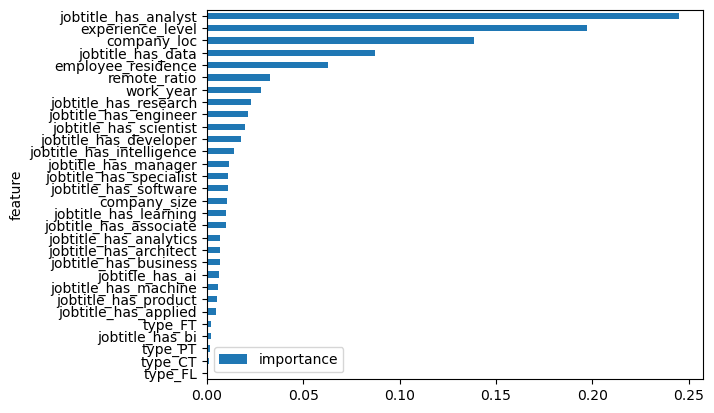

In [17]:
pipeline.fit(X, y)

feature_importances = list(pipeline.named_steps['random_forest'].feature_importances_)

feature_names = []

# Retrieve feature names from ColumnTransformer
for name, transformer, columns in preprocessor.transformers_:
    if isinstance(transformer, (OneHotEncoder, CountVectorizer)):
        # Extract feature names from OneHotEncoder and CountVectorizer
        if hasattr(transformer, 'get_feature_names_out'):
            transformed_names = transformer.get_feature_names_out(columns)
            # Add prefix if CountVectorizer
            if name == "countvectorizer_job":
                transformed_names = [f"jobtitle_has_{word}" for word in transformed_names]
        else:
            transformed_names = columns  # Fallback if feature names are not available
    else:
        transformed_names = columns if isinstance(columns, list) else [str(c) for c in columns]

    feature_names.extend(transformed_names)

feature_names = [f for f in feature_names if type(f)==str]

pd.DataFrame().from_dict({'feature': feature_names, 'importance': feature_importances}).sort_values(by='importance', ascending = True).set_index('feature').plot(kind = 'barh')
plt.show()

### Summary

In [18]:
model_df = pd.DataFrame().from_dict(models).sort_values(by="rmse")
best_model = model_df.iloc[0]

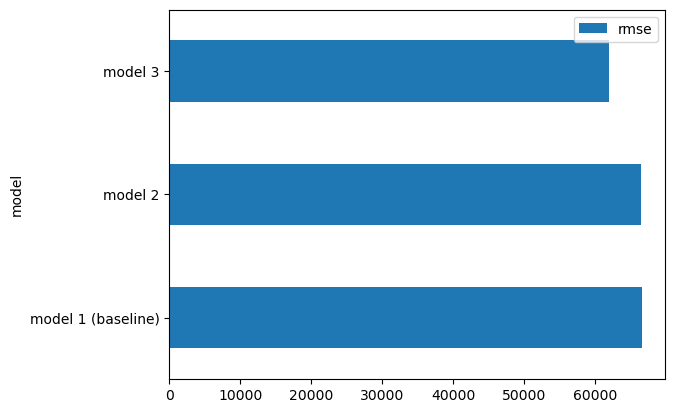

In [19]:
model_df.set_index('model').sort_values(by="rmse", ascending=False).plot(kind = 'barh')
plt.show()

In [20]:
print(f"The best model is {best_model['model']}. Its RMSE score was {best_model['rmse'].round(0)}.")

The best model is model 3. Its RMSE score was 61946.0.
